<a href="https://colab.research.google.com/github/diogoruivo47/Data-Mining/blob/chiel/optimal_cluster_count%2Bpartitioningmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# !pip install kneed
!pip install minisom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.26.1 which is incompatible.
tensorflow-metadata 1.13

In [2]:
from IPython import get_ipython
from IPython.display import display
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster



In [3]:
df = pd.read_csv('data_clean.csv')

In [9]:
pd.set_option("display.max_columns", None)

df = df.drop(columns=['Unnamed: 0'])
df.columns

KeyError: "['Unnamed: 0'] not found in axis"

In [11]:
columns_to_scale = ['CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle_Dishes', 'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

# Using numpy's log1p for logarithmic scaling (adds 1 before taking log to handle zeros)
df[columns_to_scale] = np.log1p(df[columns_to_scale])

In [14]:
df.describe()

,vendor_count,product_count,is_chain,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken_Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,Total_Orders_Per_Client,mnt,mnt_Per_Order,Items_Per_Order,frq,rcn,activity,Loyalty,Age_Group,CLV_Score,Orders_Night,Orders_Dawn,Orders_Morning,Orders_Afternoon,Orders_Evening,Orders_Dusk,RFM_Score,customer_region_0,customer_region_1,customer_region_2,customer_region_3
count,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.00000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000,31737.000000
mean,2.918581,4.932445,2.252891,0.888364,1.015187,0.808127,1.086393,0.391811,0.111254,0.191453,0.248405,0.149683,0.159268,0.264351,0.491319,0.485702,0.142067,0.513153,0.398438,0.166312,0.558339,0.570029,0.593503,0.622081,0.680814,0.655796,0.707471,3.686927,33.267142,9.844285,1.283130,0.347879,26.941015,36.45061,0.161565,1.771749,0.066017,0.285219,0.331348,1.078394,1.048020,1.336201,0.308851,2.508433,0.117686,0.278193,0.300911,0.303211
std,2.035818,3.931106,1.952278,1.096110,0.605378,1.224583,1.509538,0.930244,0.552123,0.609571,0.756377,0.611424,0.626061,0.801833,1.051639,1.038530,0.561735,1.035424,1.072577,0.617140,1.015171,1.045785,1.047444,1.071099,1.089727,1.071256,1.169202,2.612549,26.736028,6.222479,0.350075,0.390181,22.939355,29.40898,0.228829,0.791278,0.040343,0.907566,0.946374,2.093201,1.834232,2.336247,0.989525,0.606241,0.322241,0.448116,0.458661,0.459653
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.370000,0.370000,1.000000,0.022222,0.000000,1.00000,0.000000,0.000000,0.011496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,13.020000,5.070000,1.000000,0.076923,8.000000,4.00000,0.000000,1.000000,0.030806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.050000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,24.200000,8.220000,1.166667,0.134328,20.000000,35.00000,0.000000,2.000000,0.055885,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.400000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,7.000000,3.000000,2.000000,1.000000,1.903599,2.554122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,45.180000,12.920000,1.500000,0.600000,41.000000,63.00000,0.333333,2.000000,0.093041,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.950000,0.000000,1.000000,1.000000,1.000000
max,8.000000,14.000000,6.000000,3.000000,2.000000,5.639102,6.799847,5.439035,5.790266,5.396623,6.607636,5.442721,5.548337,5.736798,6.151306,6.561229,5.620799,5.905580,6.12128

In [8]:


# Calculate total spend across all cuisines

vendor_binner = ContinuousOptimalBinning(
    name='vendor_count',
    dtype='numerical',
    max_n_prebins=8,  # Since 75th percentile is 4.0, 8 bins should capture the distribution well
    monotonic_trend='auto',  # Let's see if more vendors correlates with spending
    min_prebin_size=0.05
)

vendor_binner.fit(df['vendor_count'], df['Total_Orders_Per_Client'])


(CVXPY) Dec 03 11:00:12 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 03 11:00:12 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


ContinuousOptimalBinning(max_n_prebins=8, name='vendor_count')

In [ ]:
#scaling


In [15]:
# fix dit vgm doe ik dubbel PCA en dat is dom

import numpy as np
import pandas as pd

def apply_pca(df, variance_threshold=0.8):
    """Apply PCA to retain specified variance threshold"""
    pca = PCA(sc_df)
    pca_data = pca.fit_transform(sc_df)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    pca = PCA(n_components=n_components)
    return pca.fit_transform(sc_df)


In [21]:
from sklearn.preprocessing import MinMaxScaler
# Store column names
cui_columns = [
    'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
    'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
    'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

region_columns = ['customer_region_0', 'customer_region_1', 'customer_region_2']

# Create new DataFrame
sc_df = df.copy()

# Just scale the already-logged CUI columns
scaler = MinMaxScaler()
sc_df[cui_columns] = scaler.fit_transform(sc_df[cui_columns])

# Region columns remain unchanged
sc_df[region_columns] = df[region_columns]

In [ ]:
df.columns


Index(['Unnamed: 0', 'customer_region_0', 'customer_region_1',
       'customer_region_2', 'customer_region_3', 'vendor_count',
       'product_count', 'is_chain', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
       'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'Total_Orders_Per_Client',
       'mnt', 'mnt_Per_Order', 'Items_Per_Order', 'frq', 'rcn', 'activity',
       'Loyalty', 'Age_Group', 'CLV_Score', 'Orders_Night', 'Orders_Dawn',
       'Orders_Morning', 'Orders_Afternoon', 'Orders_Evening', 'Orders_Dusk',
       'RFM_Score'],
      dtype='object')

In [16]:
value_engagement_metrics = [
    # Value
    'mnt', 'mnt_Per_Order', 'CLV_Score', 'RFM_Score',
    # Engagement
    'activity', 'Loyalty', 'frq', 'rcn' ]

preference_metrics = [
    # Cuisine preferences
    'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
    'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle_Dishes',
    'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai'
]

shopping_behavior_metrics = [
    # Shopping patterns
    'vendor_count', 'product_count', 'is_chain', 'last_promo',
    'payment_method', 'Items_Per_Order',
    # Timing preferences
    'Orders_Night', 'Orders_Dawn', 'Orders_Morning', 'Orders_Afternoon',
    'Orders_Evening', 'Orders_Dusk',
    'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6'
]

demographic_metrics = [
    'customer_region_0', 'customer_region_1', 'customer_region_2',
    'customer_region_3', 'Age_Group'
]



In [17]:
# value_engagement_metrics
# preference_metrics
# shopping_behavior_metrics
# demographic_metrics

df_val = df[value_engagement_metrics].copy()
df_pref = df[preference_metrics].copy()
df_shop = df[shopping_behavior_metrics].copy()
df_dem = df[demographic_metrics].copy()

In [18]:
def analyze_clusters(sc_df, max_clusters=10):
    """Analyze optimal number of clusters using PCA-transformed data"""
    # Apply PCA
    pca_data = apply_pca(sc_df)

    # R-squared analysis
    r_squared = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_data)
        r_squared.append(1 - kmeans.inertia_ / np.sum((pca_data - pca_data.mean(axis=0))**2))

    # Elbow method
    inertias = []
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pca_data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(pca_data, kmeans.labels_))

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # R-squared plot
    axes[0,0].plot(range(1, max_clusters + 1), r_squared, 'bo-')
    axes[0,0].set_title('R-squared Analysis')
    axes[0,0].set_xlabel('Number of Clusters')
    axes[0,0].set_ylabel('R-squared')

    # Elbow plot
    axes[0,1].plot(range(2, max_clusters + 1), inertias, 'ro-')
    axes[0,1].set_title('Elbow Method')
    axes[0,1].set_xlabel('Number of Clusters')
    axes[0,1].set_ylabel('Inertia')

    # Silhouette plot
    axes[1,0].plot(range(2, max_clusters + 1), silhouette_scores, 'go-')
    axes[1,0].set_title('Silhouette Analysis')
    axes[1,0].set_xlabel('Number of Clusters')
    axes[1,0].set_ylabel('Silhouette Score')

    # Dendrogram
    linkage_matrix = linkage(pca_data, method='ward')
    dendrogram(linkage_matrix, ax=axes[1,1])
    axes[1,1].set_title('Hierarchical Clustering Dendrogram')

    plt.tight_layout()
    return plt.gcf()

def print_analysis_summary(df, optimal_k):
    """Print summary statistics for the chosen number of clusters"""
    pca_data = apply_pca(df)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(pca_data)

    print(f"Analysis Summary for {optimal_k} clusters:")
    print(f"Silhouette Score: {silhouette_score(pca_data, labels):.3f}")
    print(f"Inertia: {kmeans.inertia_:.3f}")

    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    print("\nCluster Sizes:")
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} samples")

Analysis Summary for 4 clusters:
Silhouette Score: 0.403
Inertia: 11948229.173

Cluster Sizes:
Cluster 0: 5656 samples
Cluster 1: 10285 samples
Cluster 2: 6995 samples
Cluster 3: 8801 samples


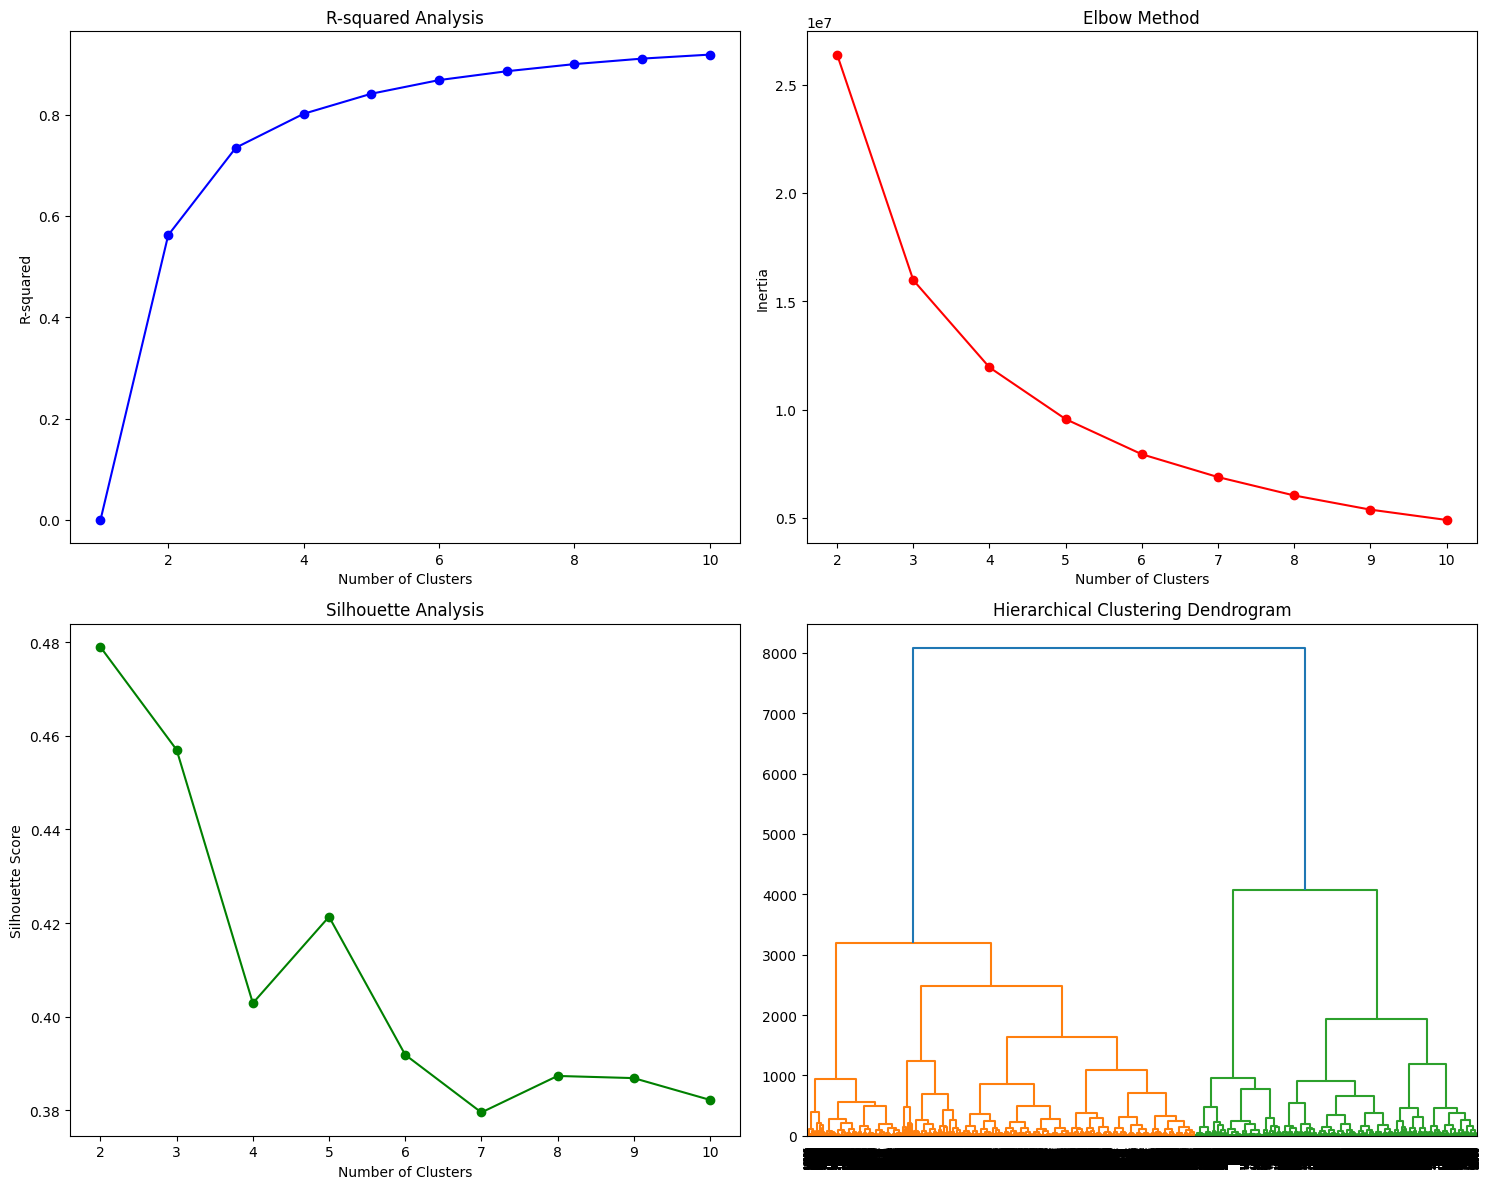

In [22]:
df = pd.DataFrame(sc_df)
fig = analyze_clusters(sc_df)
print_analysis_summary(sc_df, optimal_k=4)

In [ ]:
def evaluate_clustering(data, labels, name):
    """Calculate clustering metrics"""
    if len(np.unique(labels[labels >= 0])) <= 1:
        return None

    metrics = {
        'Silhouette': silhouette_score(data, labels),
        'Calinski-Harabasz': calinski_harabasz_score(data, labels),
        'Davies-Bouldin': davies_bouldin_score(data, labels),
        'R-squared': 1 - np.sum((data - np.mean(data, axis=0))**2) / np.sum((data - data.mean())**2)
    }
    return metrics

def compare_clustering_algorithms(df, n_clusters=4):
    """Compare different clustering algorithms"""
    # Apply PCA
    data = apply_pca(df)
    results = {}

    # K-means++
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(data)
    results['K-means++'] = evaluate_clustering(data, kmeans_labels, 'K-means++')

    # Hierarchical
    linkage_matrix = linkage(data, method='ward')
    hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    results['Hierarchical'] = evaluate_clustering(data, hierarchical_labels, 'Hierarchical')

    # SOM
    som_dim = int(np.sqrt(n_clusters))
    som = MiniSom(som_dim, som_dim, data.shape[1], sigma=1.0, random_seed=42)
    som.train_random(data, 1000)
    som_labels = np.array([som.winner(x) for x in data])
    som_labels = np.ravel_multi_index(som_labels.T, (som_dim, som_dim))
    results['SOM'] = evaluate_clustering(data, som_labels, 'SOM')

    # DBSCAN
    eps = np.mean([np.linalg.norm(data[i] - data[j])
                  for i in range(len(data))
                  for j in range(i + 1, len(data))]) / (2 * n_clusters)
    dbscan = DBSCAN(eps=eps, min_samples=int(np.log(len(data))))
    dbscan_labels = dbscan.fit_predict(data)
    if len(np.unique(dbscan_labels[dbscan_labels >= 0])) > 1:
        results['DBSCAN'] = evaluate_clustering(data, dbscan_labels, 'DBSCAN')

    return pd.DataFrame(results).T

def plot_comparison(results):
    """Plot comparison of clustering metrics"""
    metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'R-squared']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        results[metric].plot(kind='bar', ax=ax)
        ax.set_title(metric)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

def run_clustering_comparison(df, n_clusters=4):
    """Run complete clustering comparison"""
    results = compare_clustering_algorithms(df, n_clusters)
    fig = plot_comparison(results)
    return results, fig

In [24]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00


Number of components selected: 2
Total variance explained: 0.8621


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


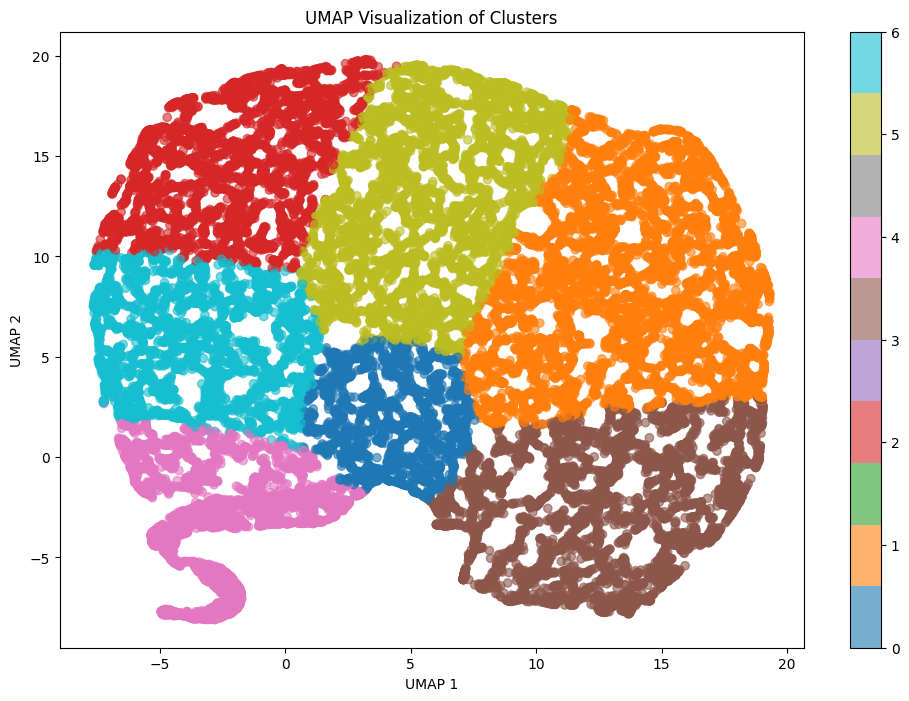


=== Clustering Analysis Report ===
Number of clusters: 7
Silhouette Score: 0.3797

Cluster Sizes:
Cluster 0: 2273 samples (7.16%)
Cluster 1: 7315 samples (23.05%)
Cluster 2: 4023 samples (12.68%)
Cluster 3: 5305 samples (16.72%)
Cluster 4: 3727 samples (11.74%)
Cluster 5: 5487 samples (17.29%)
Cluster 6: 3607 samples (11.37%)

Feature Statistics per Cluster:

Cluster 0 Characteristics:
Top distinguishing features:
- mnt_Per_Order: 1.10 std higher than average
- mnt: 0.96 std higher than average
- Items_Per_Order: 0.94 std higher than average
- customer_region_3: 0.70 std higher than average
- CUI_Street_Food/Snacks: 0.60 std higher than average

Cluster 1 Characteristics:
Top distinguishing features:
- activity: 0.89 std lower than average
- Total_Orders_Per_Client: 0.70 std lower than average
- product_count: 0.70 std lower than average
- mnt: 0.70 std lower than average
- vendor_count: 0.63 std lower than average

Cluster 2 Characteristics:
Top distinguishing features:
- activity: 1

In [25]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

def apply_pca(df, variance_threshold=0.80):
    # Remove any non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Apply PCA directly without scaling
    pca = PCA()
    pca_data = pca.fit_transform(numeric_df)

    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Find number of components needed for desired variance
    n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

    # Reduce to selected number of components
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(numeric_df)

    print(f"Number of components selected: {n_components}")
    print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

    return pca_data

def analyze_clusters(pca_data, df, n_clusters=7):
    # Initialize KMeans with the optimized parameters
    kmeans = KMeans(
        n_clusters=n_clusters,
        max_iter=4119,
        n_init=155,
        tol=7.631932953284075e-05,
        init='k-means++',
        random_state=42
    )

    # Fit KMeans
    clusters = kmeans.fit_predict(pca_data)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(pca_data, clusters)

    # UMAP Dimensionality Reduction for Visualization
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(pca_data)

    # Create visualization
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                         c=clusters, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('UMAP Visualization of Clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

    # Cluster Analysis Report
    print("\n=== Clustering Analysis Report ===")
    print(f"Number of clusters: {n_clusters}")
    print(f"Silhouette Score: {silhouette_avg:.4f}")

    # Cluster sizes
    cluster_sizes = pd.Series(clusters).value_counts().sort_index()
    print("\nCluster Sizes:")
    for cluster, size in cluster_sizes.items():
        print(f"Cluster {cluster}: {size} samples ({size/len(clusters)*100:.2f}%)")

    # Feature analysis per cluster
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = clusters

    print("\nFeature Statistics per Cluster:")
    # Only use numeric columns for analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cluster_stats = df_with_clusters.groupby('Cluster')[numeric_cols].agg(['mean', 'std'])

    # Print feature statistics for each cluster
    for cluster in range(n_clusters):
        print(f"\nCluster {cluster} Characteristics:")

        # Find distinguishing features
        overall_means = df_with_clusters[numeric_cols].mean()
        cluster_means = df_with_clusters[df_with_clusters['Cluster'] == cluster][numeric_cols].mean()

        # Calculate z-scores of differences
        differences = (cluster_means - overall_means) / df_with_clusters[numeric_cols].std()

        # Print top distinguishing features
        print("Top distinguishing features:")
        top_features = differences.abs().sort_values(ascending=False).head(5)
        for feature in top_features.index:
            direction = "higher" if differences[feature] > 0 else "lower"
            print(f"- {feature}: {abs(differences[feature]):.2f} std {direction} than average")

    return clusters, embedding

# Now run the complete analysis
pca_data = apply_pca(sc_df)
clusters, embedding = analyze_clusters(pca_data, sc_df)

In [7]:
results, fig = run_clustering_comparison(df, n_clusters=4)
print(results)
plt.show()

NameError: name 'run_clustering_comparison' is not defined

In [ ]:
# def optimize_kmeans_random(data, n_clusters=4, n_iter=20):
#     param_distributions = {
#         'max_iter': [300, 500, 700],
#         'n_init': [10, 15, 20],
#         'init': ['k-means++']
#     }

#     best_score = -1
#     best_model = None
#     best_params = None
#     scores = []
#     params = []

#     for _ in range(n_iter):
#         params_combo = {k: np.random.choice(v) for k,v in param_distributions.items()}
#         model = KMeans(n_clusters=n_clusters, **params_combo, random_state=42)
#         model.fit(data)
#         score = silhouette_score(data, model.labels_)

#         if score > best_score:
#             best_score = score
#             best_model = model
#             best_params = params_combo

#         scores.append(score)
#         params.append(params_combo)

#     print(f"Best silhouette score: {best_score}")
#     return best_model, best_params, list(zip(params, scores))
# # Usage
# data = apply_pca(df)
# best_model, best_params, results = optimize_kmeans_random(data)
# print(f"\nBest parameters: {best_params}")
# best_labels = best_model.predict(data)

Best silhouette score: 0.3118571769765192

Best parameters: {'max_iter': 500, 'n_init': 10, 'init': 'k-means++'}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


1. Tune parameters on complete dataset first,

2. Apply optimized parameters to your split segments:

-Value-based features

-Behavioral features

-Demographic features


3. Merge segments using hierarchical clustering

4. Decision tree feature importance thing

5. Validate final segmentation with business metrics

<Figure size 1000x700 with 0 Axes>

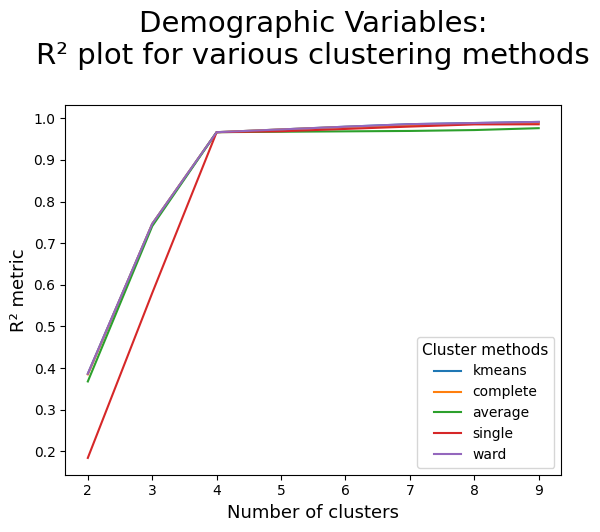

In [ ]:
datasets = {
    'Demographic': df_dem,
    'Values': df_val,
    'Preferences': df_pref,
    'Shopping': df_shop
}

for name, df in datasets.items():
    # Calculate R² scores
    r2_scores = {}
    r2_scores['kmeans'] = get_r2_scores(df, kmeans)

    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[linkage] = get_r2_scores(
            df,
            hierarchical.set_params(linkage=linkage)
        )

    plt.figure(figsize=(10, 7))
    pd.DataFrame(r2_scores).plot.line()
    plt.title(f"{name} Variables:\nR² plot for various clustering methods\n", fontsize=21)
    plt.legend(title="Cluster methods", title_fontsize=11)
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R² metric", fontsize=13)
    plt.show()

NameError: name 'clone' is not defined

In [ ]:
# Testing on K-means and Hierarchical clustering to decide amount of clusters